In [1]:
# Ran on T4 GPU via Google Colab

import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

np.random.seed(42)

In [2]:
def filepath(f):
    d = os.path.join(os.path.dirname(os.getcwd()), 'processed_data', f)
    return d

# Import training and test datasets
try:
    train_data = pd.read_csv(filepath("final_training_set.csv"))
    test_data = pd.read_csv(filepath("final_test_set.csv"))
except:
    train_data = pd.read_csv(("final_training_set.csv"))
    test_data = pd.read_csv(("final_test_set.csv"))

uid = train_data["ClaimID"]
train_data = train_data.drop(
    ["ClaimID"],
    axis = 1
)
test_data = test_data.drop(
    ["ClaimID"],
    axis = 1
)

def minmax_encode(df, col):
    """
    Return dataset including the minmax encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be numeric
    """

    maxx = df[col].max()
    minx = df[col].min()
    out = list(map(lambda x: (x-minx)/(maxx-minx), df[col]))
    new_colname = col + "_minmax"
    df[new_colname] = out
    return df.drop(
        [col],
        axis = 1
    )

def one_hot_encode(df, col):
    """
    Returns the dataset including the one hot encoded columns and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable
    """
    ohe_cols = pd.get_dummies(df[col], prefix = col)
    output = pd.concat(
        [df, ohe_cols],
        axis = 1,
    ).drop(
        [col],
        axis = 1
    )
    return output

def frequency_encode(df, col):
    """
    Returns the dataset including the frequency encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable with high cardinality
    """
    val_counts = df[col].value_counts().to_dict()
    total = len(df[col])
    out = []
    for x in df[col]:
        out.append(val_counts[x]/total)
    new_colname = col + '_freq'
    df[new_colname] = out
    df.drop(
        [col],
        axis = 1,
        inplace = True
    )

    return df

In [3]:
freq_encoded_cols = []
ohe_cols = []
num_cols = []
unique_threshold = 30

for col in train_data.columns:
    if train_data[col].nunique() == 1:
        print(col,"has been removed as it is constant")
        train_data.drop([col], axis=1, inplace=True)
    elif train_data[col].nunique() == 2: # Binary columns
        continue
    elif train_data[col].dtype in ['int64','float64']:
        train_data[col] = train_data[col].fillna(train_data[col].median())
        num_cols.append(col)
    elif train_data[col].nunique() > unique_threshold:
        freq_encoded_cols.append(col)
    elif 2 < train_data[col].nunique() <= unique_threshold:
        ohe_cols.append(col)

procedure_1 has been removed as it is constant
procedure_2 has been removed as it is constant
procedure_3 has been removed as it is constant


In [4]:
for col in train_data.columns:
    if col in num_cols:
        train_data = minmax_encode(train_data, col)
    elif col in ohe_cols:
        train_data = one_hot_encode(train_data, col)
    elif col in freq_encoded_cols:
        try:
            train_data = frequency_encode(train_data, col)
        except:
            print(col)
    elif train_data[col].nunique() == 1:
        train_data.drop(
            [col],
            axis = 1,
            inplace = True
        )
    else:
        train_data[col] = train_data[col].astype('bool')
for col in test_data.columns:
    if col in num_cols:
        test_data = minmax_encode(test_data, col)
    elif col in ohe_cols:
        test_data = one_hot_encode(test_data, col)
    elif col in freq_encoded_cols:
        try:
            test_data = frequency_encode(test_data, col)
        except:
            print(col)
    elif test_data[col].nunique() == 1:
        test_data.drop(
            [col],
            axis = 1,
            inplace = True
        )
    else:
        test_data[col] = test_data[col].astype('bool')

In [5]:
y = train_data["PotentialFraud"]
train_data.drop(
    ["PotentialFraud"],
    axis = 1,
    inplace = True
)

In [6]:
test_data = test_data[train_data.columns]

In [7]:
train_data = train_data.values.astype(np.float64)
y = y.values.astype(np.float64)
train_data.shape, y.shape

((558211, 60), (558211,))

In [8]:
X_test = test_data.values.astype(np.float64)
X_test.shape

(135392, 60)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.2, random_state=42)

## Train on the 3-way network

In [10]:
def split_data(X):
    return [X[:,:49], X[:,49:]]

trainCategoricalX, trainNumericalX = split_data(X_train)
validCategoricalX, validNumericalX = split_data(X_valid)
testCategoricalX, testNumericalX = split_data(X_test)

In [11]:
def create_mlp(dim):
	model = Sequential()
	model.add(Dense(256, input_dim=dim, activation="relu"))
	model.add(Dropout(0.1))
	model.add(Dense(512, activation="relu"))
	model.add(Dropout(0.1))
	model.add(Dense(1024, activation="relu"))
	model.add(Dropout(0.1))
	model.add(Dense(512, activation="relu"))
	return model

In [12]:
mlp_cat = create_mlp(49)
mlp_num = create_mlp(11)
combinedInput = concatenate([mlp_cat.output, mlp_num.output])
x = Dense(256, activation="relu")(combinedInput)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[mlp_cat.input, mlp_num.input], outputs=x)

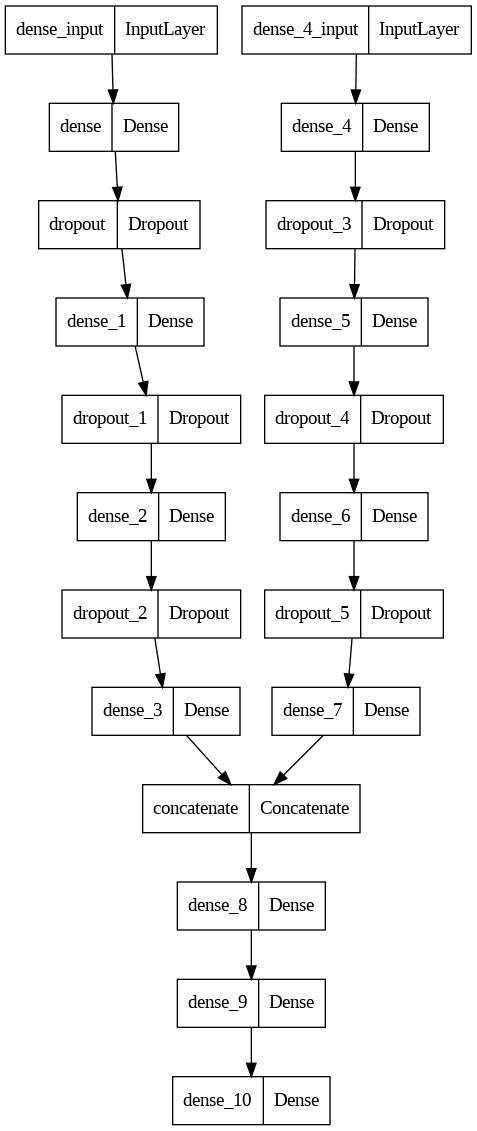

In [13]:
plot_model(model)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("[INFO] training model...")
history = model.fit(
	x=[trainCategoricalX, trainNumericalX], y=y_train,
	validation_data=([validCategoricalX, validNumericalX], y_valid),
	epochs=20, batch_size=512)
print("[INFO] predicting...")
preds = model.predict([testCategoricalX, testNumericalX])

[INFO] training model...
Epoch 1/20
873/873 [==============================] - 13s 9ms/step - loss: 0.5278 - accuracy: 0.7350 - val_loss: 0.4200 - val_accuracy: 0.8167
Epoch 2/20
873/873 [==============================] - 6s 7ms/step - loss: 0.4105 - accuracy: 0.8165 - val_loss: 0.4134 - val_accuracy: 0.8128
Epoch 3/20
873/873 [==============================] - 7s 8ms/step - loss: 0.4017 - accuracy: 0.8202 - val_loss: 0.4132 - val_accuracy: 0.8165
Epoch 4/20
873/873 [==============================] - 7s 8ms/step - loss: 0.3960 - accuracy: 0.8231 - val_loss: 0.3912 - val_accuracy: 0.8215
Epoch 5/20
873/873 [==============================] - 10s 11ms/step - loss: 0.3923 - accuracy: 0.8246 - val_loss: 0.3857 - val_accuracy: 0.8218
Epoch 6/20
873/873 [==============================] - 8s 9ms/step - loss: 0.3917 - accuracy: 0.8251 - val_loss: 0.3891 - val_accuracy: 0.8274
Epoch 7/20
873/873 [==============================] - 6s 7ms/step - loss: 0.3889 - accuracy: 0.8264 - val_loss: 0.3787 -

In [15]:
model.evaluate([trainCategoricalX, trainNumericalX], y_train), model.evaluate([validCategoricalX, validNumericalX], y_valid)

3489/3489 [==============================] - 11s 3ms/step - loss: 0.3891 - accuracy: 0.8266


([0.3474869132041931, 0.8513597249984741],
 [0.3890666961669922, 0.8265990614891052])

## Train on the regular network

In [16]:
mlp = create_mlp(60)
mlp.add(Dense(256, activation="relu"))
mlp.add(Dense(512, activation="relu"))
mlp.add(Dense(1, activation="sigmoid"))
model2 = mlp

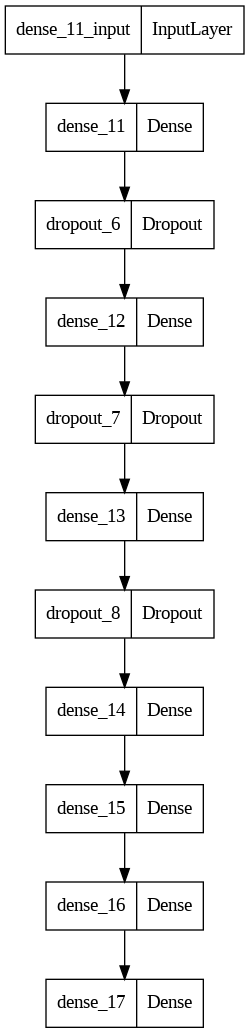

In [17]:
plot_model(model2)

In [18]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("[INFO] training model...")
history2 = model2.fit(
	x=X_train, y=y_train,
	validation_data=(X_valid, y_valid),
	epochs=50, batch_size=512)
print("[INFO] predicting...")
preds = model2.predict(X_test)

[INFO] training model...
Epoch 1/50
873/873 [==============================] - 8s 7ms/step - loss: 0.6589 - accuracy: 0.6286 - val_loss: 0.6537 - val_accuracy: 0.6327
Epoch 2/50
873/873 [==============================] - 5s 6ms/step - loss: 0.6274 - accuracy: 0.6580 - val_loss: 0.5969 - val_accuracy: 0.6725
Epoch 3/50
873/873 [==============================] - 5s 6ms/step - loss: 0.5039 - accuracy: 0.7597 - val_loss: 0.4747 - val_accuracy: 0.7816
Epoch 4/50
873/873 [==============================] - 6s 7ms/step - loss: 0.4388 - accuracy: 0.8026 - val_loss: 0.4078 - val_accuracy: 0.8208
Epoch 5/50
873/873 [==============================] - 5s 6ms/step - loss: 0.4199 - accuracy: 0.8119 - val_loss: 0.4017 - val_accuracy: 0.8212
Epoch 6/50
873/873 [==============================] - 6s 7ms/step - loss: 0.4121 - accuracy: 0.8159 - val_loss: 0.4001 - val_accuracy: 0.8203
Epoch 7/50
873/873 [==============================] - 6s 7ms/step - loss: 0.4082 - accuracy: 0.8179 - val_loss: 0.4050 - va

In [19]:
model2.evaluate(X_train, y_train), model2.evaluate(X_valid, y_valid)

3489/3489 [==============================] - 9s 3ms/step - loss: 0.4198 - accuracy: 0.8177


([0.357149213552475, 0.8441917300224304],
 [0.4197717607021332, 0.8176867365837097])

## Metrics

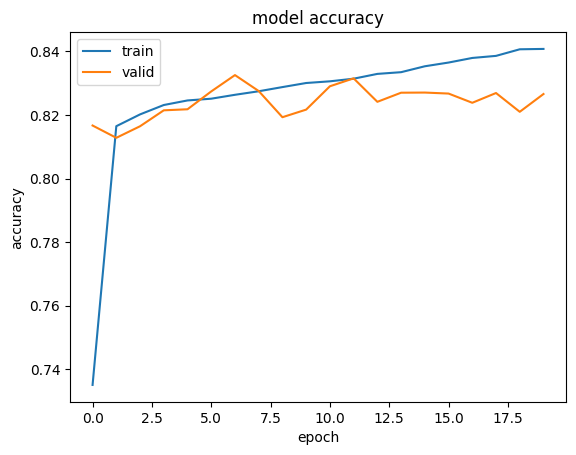

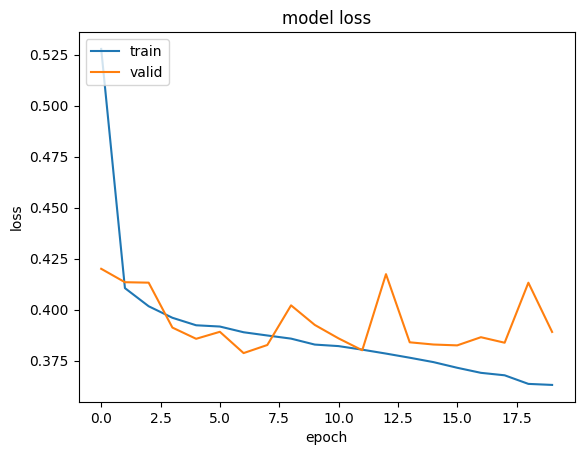

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

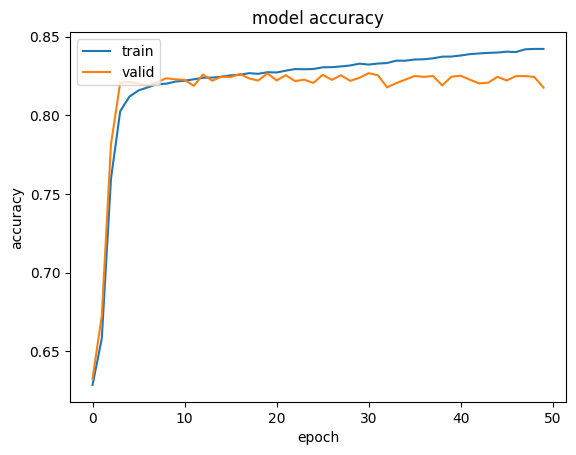

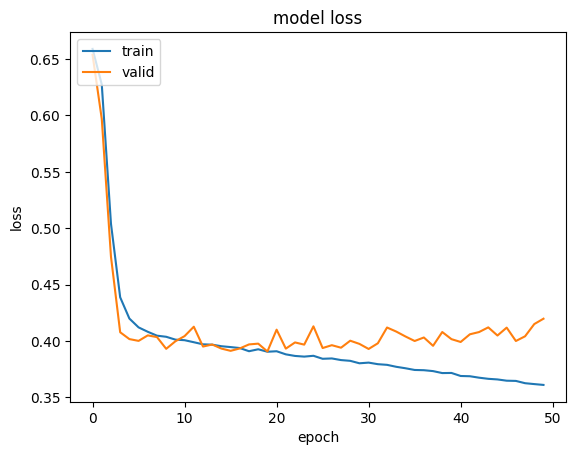

In [21]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
pred1_train = np.round(model.predict([trainCategoricalX, trainNumericalX])).ravel()
pred1_valid = np.round(model.predict([validCategoricalX, validNumericalX])).ravel()

3489/3489 [==============================] - 9s 2ms/step


In [23]:
pred2_train = np.round(model2.predict(X_train)).ravel()
pred2_valid = np.round(model2.predict(X_valid)).ravel()

3489/3489 [==============================] - 8s 2ms/step


In [24]:
print('Model 1 Train')
print('Accuracy:', accuracy_score(y_train, pred1_train))
print('F1 Score:', f1_score(y_train, pred1_train))
print('Precision:', precision_score(y_train, pred1_train))
print('Recall:', recall_score(y_train, pred1_train))
print(confusion_matrix(y_train, pred1_train))
print()
print('Model 1 Valid')
print('Accuracy:', accuracy_score(y_valid, pred1_valid))
print('F1 Score:', f1_score(y_valid, pred1_valid))
print('Precision:', precision_score(y_valid, pred1_valid))
print('Recall:', recall_score(y_valid, pred1_valid))
print(confusion_matrix(y_valid, pred1_valid))
print(), print()
print('Model 2 Train')
print('Accuracy:', accuracy_score(y_train, pred2_train))
print('F1 Score:', f1_score(y_train, pred2_train))
print('Precision:', precision_score(y_train, pred2_train))
print('Recall:', recall_score(y_train, pred2_train))
print(confusion_matrix(y_train, pred2_train))
print()
print('Model 2 Valid')
print('Accuracy:', accuracy_score(y_valid, pred2_valid))
print('F1 Score:', f1_score(y_valid, pred2_valid))
print('Precision:', precision_score(y_valid, pred2_valid))
print('Recall:', recall_score(y_valid, pred2_valid))
print(confusion_matrix(y_valid, pred2_valid))

Model 1 Train
Accuracy: 0.8513597033374537
F1 Score: 0.7742905136592697
Precision: 0.9205902567212452
Recall: 0.6681141475608969
[[266336   9821]
 [ 56557 113854]]

Model 1 Valid
Accuracy: 0.8265990702507099
F1 Score: 0.7346009898139644
Precision: 0.8767589501930755
Recall: 0.6321104164209036
[[65492  3766]
 [15593 26792]]


Model 2 Train
Accuracy: 0.8441917020476165
F1 Score: 0.749941599491107
Precision: 0.9675074183976261
Recall: 0.612260945596235
[[272653   3504]
 [ 66075 104336]]

Model 2 Valid
Accuracy: 0.817686733606227
F1 Score: 0.7025225804565783
Precision: 0.9230710143257672
Recall: 0.5670402264952223
[[67255  2003]
 [18351 24034]]
